## Import libraries

In [82]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display_html
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from scipy.stats import poisson, nbinom

## Load data - exports

In [83]:
ROOT = Path.cwd().parent

data_path = ROOT / 'data'

In [84]:
df = pd.read_csv(data_path / 'dati_leo_assoluti.csv')
df = df.reset_index(drop=True)

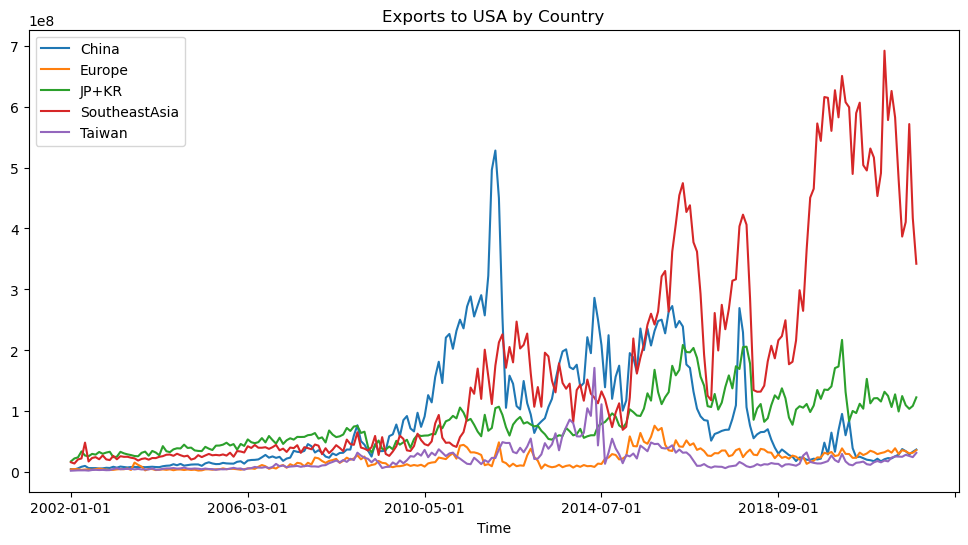

In [85]:
df.set_index('Time').plot(figsize=(12, 6), title='Exports to USA by Country')
plt.show()

## Model

In [89]:
# Uncomment if you want normalized values
df_normalized = pd.read_csv(data_path / 'dati_leo_normalizzati.csv')
df_normalized = df_normalized.reset_index(drop=True)
df_normalized = df_normalized.drop(columns=['Europe', 'total'])
df_normalized

,Time,China,JP+KR,SoutheastAsia,Taiwan
0,2002-01-01,0.110311,0.380993,0.352239,0.054684
1,2002-02-01,0.093534,0.454315,0.287546,0.057884
2,2002-03-01,0.107718,0.406185,0.349512,0.052608
3,2002-04-01,0.123506,0.467669,0.310324,0.044436
4,2002-05-01,0.110933,0.290828,0.515878,0.033958
...,...,...,...,...,...
235,2021-08-01,0.062298,0.204443,0.632360,0.041596
236,2021-09-01,0.055998,0.177974,0.663774,0.046366
237,2021-10-01,0.038418,0.136539,0.749306,0.035138
238,2021-11-01,0.054520,0.176605,0.676466,0.040333


In [90]:
df_tariffs = pd.DataFrame()
df_tariffs['Time'] = df_normalized['Time']
df_tariffs

,Time
0,2002-01-01
1,2002-02-01
2,2002-03-01
3,2002-04-01
4,2002-05-01
...,...
235,2021-08-01
236,2021-09-01
237,2021-10-01
238,2021-11-01


In [91]:
# Initialize columns
df_tariffs['china tariff'] = 0.0
df_tariffs['jp + kr tariff'] = 0.0
df_tariffs['sea tariff'] = 0.0
df_tariffs['taiwan tariff'] = 0.0

# Convert 'Time' column to datetime
df_tariffs['Time'] = pd.to_datetime(df_tariffs['Time'])

# Apply tariff values based on date ranges
df_tariffs.loc[df_tariffs['Time'] < pd.Timestamp('2012-07-05'), ['china tariff', 'jp + kr tariff', 'sea tariff', 'taiwan tariff']] = 0.0

df_tariffs.loc[
    (df_tariffs['Time'] >= pd.Timestamp('2012-07-05')) & (df_tariffs['Time'] < pd.Timestamp('2012-12-01')),
    'china tariff'
] = 0.3463

df_tariffs.loc[
    (df_tariffs['Time'] >= pd.Timestamp('2012-12-01')) & (df_tariffs['Time'] < pd.Timestamp('2014-12-01')),
    'china tariff'
] = 0.4651

df_tariffs.loc[
    (df_tariffs['Time'] >= pd.Timestamp('2014-12-01')) & (df_tariffs['Time'] < pd.Timestamp('2018-02-01')),
    'china tariff'
] = 0.9055

df_tariffs.loc[
    (df_tariffs['Time'] >= pd.Timestamp('2014-12-01')) & (df_tariffs['Time'] < pd.Timestamp('2018-02-01')),
    'taiwan tariff'
] = 0.1517

df_tariffs.loc[
    (df_tariffs['Time'] >= pd.Timestamp('2018-02-01')) & (df_tariffs['Time'] < pd.Timestamp('2019-02-01')),
    ['china tariff', 'jp + kr tariff', 'sea tariff', 'taiwan tariff']
] = 0.30

df_tariffs.loc[
    (df_tariffs['Time'] >= pd.Timestamp('2019-02-01')) & (df_tariffs['Time'] < pd.Timestamp('2020-02-01')),
    ['china tariff', 'jp + kr tariff', 'sea tariff', 'taiwan tariff']
] = 0.25

df_tariffs.loc[
    df_tariffs['Time'] >= pd.Timestamp('2021-02-01'),
    ['china tariff', 'jp + kr tariff', 'sea tariff', 'taiwan tariff']
] = 0.20

    

In [92]:
df_tariffs.head()

,Time,china tariff,jp + kr tariff,sea tariff,taiwan tariff
0,2002-01-01,0.0,0.0,0.0,0.0
1,2002-02-01,0.0,0.0,0.0,0.0
2,2002-03-01,0.0,0.0,0.0,0.0
3,2002-04-01,0.0,0.0,0.0,0.0
4,2002-05-01,0.0,0.0,0.0,0.0


In [93]:
df_tariffs.to_csv(data_path / 'tariffs_final.csv', index=False)

In [94]:
df_tariffs.shape

(240, 5)

In [104]:
df_normalized.shape

(240, 5)

## Model

In [112]:
def lotka_volterra_with_tariffs(t, X,tariffs, r1, r2, r3, r4, 
                                a11, a12, a13, a14,
                                a21, a22, a23, a24,
                                a31, a32, a33, a34,
                                a41, a42, a43, a44,
                                tau):
    X1, X2, X3, X4 = X
    trf1, trf2, trf3, trf4 = tariffs.iloc[int(t), 1:]  

    dx1dt = r1 * X1 * (1 - (1 + tau*trf1)*a11*X1 + (1 - tau*trf2) * a12 * X2 + (1 - tau*trf3) * a13 * X3 + (1 - tau*trf4) * a14 * X4)
    dx2dt = r2 * X2 * (1 - (1 - tau*trf1)*a21*X1 + (1 + tau*trf2) * a22 * X2 + (1 - tau*trf3) * a23 * X3 + (1 - tau*trf4) * a24 * X4)
    dx3dt = r3 * X3 * (1 - (1 - tau*trf1)*a31*X1 + (1 - tau*trf2) * a32 * X2 + (1 + tau*trf3) * a33 * X3 + (1 - tau*trf4) * a34 * X4)
    dx4dt = r4 * X4 * (1 - (1 - tau*trf1)*a41*X1 + (1 - tau*trf2) * a42 * X2 + (1 - tau*trf3) * a43 * X3 + (1 + tau*trf4) * a44 * X4)

    return [dx1dt, dx2dt, dx3dt, dx4dt]


In [118]:
def lotka_volterra_with_tariffs_end(t, X, tariffs,
                                r1, r2, r3, r4,
                                a11, a12, a13, a14,
                                a21, a22, a23, a24,
                                a31, a32, a33, a34,
                                a41, a42, a43, a44,
                                b11, b12, b13, b14,
                                b21, b22, b23, b24,
                                b31, b32, b33, b34,
                                b41, b42, b43, b44):
    X1, X2, X3, X4 = X
    tariff_1, tariff_2, tariff_3, tariff_4 = tariffs.iloc[int(t), 1:]

    dx1dt = r1 * X1 * (1 - a11*X1 - a12*X2 - a13*X3 - a14*X4) - b11 * X2 * X3 * X4 * tariff_1 + b12 * X2 * tariff_2 + b13 * X3 * tariff_3 + b14 * X4 * tariff_4
    dx2dt = r2 * X2 * (1 - a21*X1 - a22*X2 - a23*X3 - a24*X4) + b21 * X1 * tariff_1 - b22 * X1 * X3 * X4 * tariff_2 + b23 * X3 * tariff_3 + b24 * X4 * tariff_4
    dx3dt = r3 * X3 * (1 - a31*X1 - a32*X2 - a33*X3 - a34*X4) + b31 * X1 * tariff_1 + b32 * X2 * tariff_2 - b33 * X1 * X2 * X4 * tariff_3 + b34 * X4 * tariff_4
    dx4dt = r4 * X4 * (1 - a41*X1 - a42*X2 - a43*X3 - a44*X4) + b41 * X1 * tariff_1 + b42 * X2 * tariff_2 + b43 * X3 * tariff_3 - b44 * X1 * X2 * X3 * tariff_4

    return [dx1dt, dx2dt, dx3dt, dx4dt]

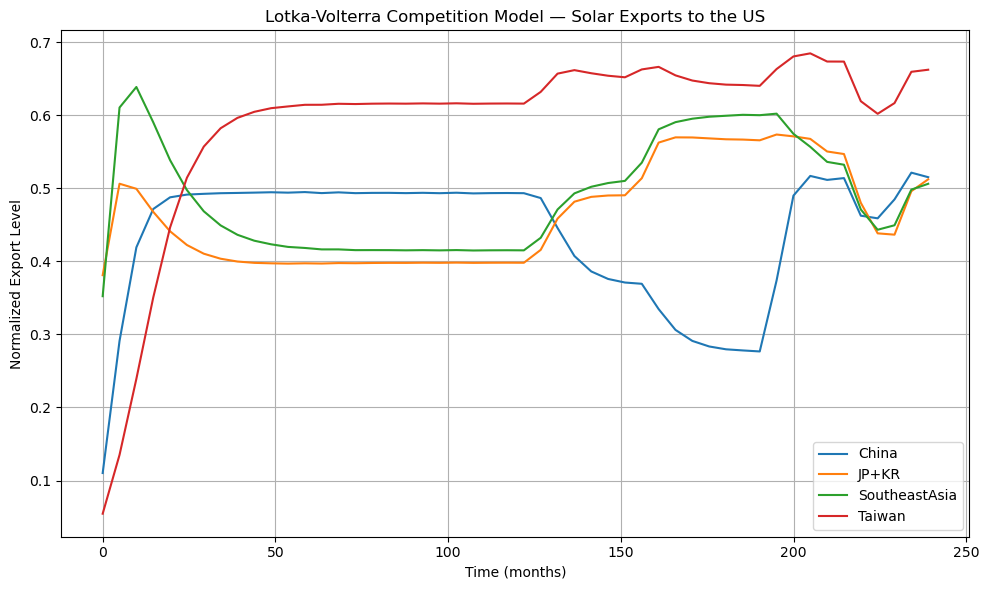

In [119]:
# Uncomment to use parameters for normalized values
params = {
    'r1': 0.5, 'r2': 0.3, 'r3': 0.4, 'r4': 0.35,
    'a11': 1.0, 'a12': 0.6, 'a13': 0.2, 'a14': 0.3,
    'a21': 0.3, 'a22': 1.0, 'a23': 0.5, 'a24': 0.4,
    'a31': 0.4, 'a32': 0.2, 'a33': 1.0, 'a34': 0.5,
    'a41': 0.2, 'a42': 0.3, 'a43': 0.4, 'a44': 1.0,
    'b11': 0.1, 'b12': 0.1, 'b13': 0.1, 'b14': 0.1,
    'b21': 0.1, 'b22': 0.1, 'b23': 0.1, 'b24': 0.1,
    'b31': 0.1, 'b32': 0.1, 'b33': 0.1, 'b34': 0.1,
    'b41': 0.1, 'b42': 0.1, 'b43': 0.1, 'b44': 0.1
}

# # Uncomment to use parameters for absolute values
# params = {
#     'r1': 50.0, 'r2': 30.0, 'r3': 40.0, 'r4': 35.0,
#     'a11': 0.00001, 'a12': 0.000006, 'a13': 0.000004, 'a14': 0.000003,
#     'a21': 0.000004, 'a22': 0.000002, 'a23': 0.000003, 'a24': 0.000004,
#     'a31': 0.000004, 'a32': 0.000002, 'a33': 0.000003, 'a34': 0.000005,
#     'a41': 0.000006, 'a42': 0.000004, 'a43': 0.000004, 'a44': 0.00001,
#     'b11': 0.000001, 'b21': 0.000001, 'b31': 0.000001, 'b41': 0.000001,
#     'b12': 0.000001, 'b22': 0.000001, 'b32': 0.000001, 'b42': 0.000001,
#     'b13': 0.000001, 'b23': 0.000001, 'b33': 0.000001, 'b43': 0.000001,
#     'b14': 0.000001, 'b24': 0.000001, 'b34': 0.000001, 'b44': 0.000001
# }


# Initial conditions (example, adjust as needed)
X0 = df_normalized.iloc[0, 1:].values.tolist()  # Use the first row of normalized data as initial conditions

# Time span and evaluation points
t_span = (0, 239)
t_eval = np.linspace(*t_span)

# Solve the system
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_with_tariffs_end(t, X, df_tariffs, **params),
    t_span=t_span,
    y0=X0,
    t_eval=t_eval
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='China')
plt.plot(sol.t, sol.y[1], label='JP+KR')
plt.plot(sol.t, sol.y[2], label='SoutheastAsia')
plt.plot(sol.t, sol.y[3], label='Taiwan')
plt.title('Lotka-Volterra Competition Model — Solar Exports to the US')
plt.xlabel('Time (months)')
plt.ylabel('Normalized Export Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Calibration - Least Squares

In [124]:
china_data = df_normalized['China']
jpkr_data = df_normalized['JP+KR']
southeastasia_data = df_normalized['SoutheastAsia']
taiwan_data = df_normalized['Taiwan']

# Stack data for comparison
data = np.vstack([china_data, jpkr_data, southeastasia_data, taiwan_data])  # shape (4, T)
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months

In [121]:
def residuals(params, X0, tariffs, t_data, data):
    r1, r2, r3, r4 = params[:4]
    a11, a12, a13, a14 = params[4:8]
    a21, a22, a23, a24 = params[8:12]
    a31, a32, a33, a34 = params[12:16]
    a41, a42, a43, a44 = params[16:20]
    b11, b12, b13, b14 = params[20:24]
    b21, b22, b23, b24 = params[24:28]
    b31, b32, b33, b34 = params[28:32]
    b41, b42, b43, b44 = params[32:36]

    sol = solve_ivp(
        fun=lambda t, X: lotka_volterra_with_tariffs_end(
            t, X, tariffs, r1, r2, r3, r4,
            a11, a12, a13, a14,
            a21, a22, a23, a24,
            a31, a32, a33, a34,
            a41, a42, a43, a44,
            b11, b12, b13, b14,
            b21, b22, b23, b24,
            b31, b32, b33, b34,
            b41, b42, b43, b44
        ),
        t_span=(t_data[0], t_data[-1]),
        y0=X0,
        t_eval=t_data,
        method='RK45'
    )

    if sol.y.shape[1] != len(t_data):
        return np.ones(data.size) * 1e6

    return (sol.y - data).ravel()

In [125]:
# Initial guess for 4 regions: r1, r2, r3, r4, a11, a12, a13, a14, ..., b44 (total 36 params)
initial_guess = [
    0.5, 0.3, 0.4, 0.35,   # r1, r2, r3, r4
    1.0, 0.6, 0.2, 0.3,    # a11, a12, a13, a14
    0.3, 1.0, 0.5, 0.4,    # a21, a22, a23, a24
    0.4, 0.2, 1.0, 0.5,    # a31, a32, a33, a34
    0.2, 0.3, 0.4, 1.0,    # a41, a42, a43, a44
    0.1, 0.1, 0.1, 0.1,     # b11, b12, b13, b14
    0.1, 0.1, 0.1, 0.1,     # b21, b22, b23, b24
    0.1, 0.1, 0.1, 0.1,     # b31, b32, b33, b34
    0.1, 0.1, 0.1, 0.1      # b41, b42, b43, b44
]

# Initial export levels from your data
X0 = data[:, 0]

# Fit the model
result = least_squares(residuals, initial_guess, args=(X0, df_tariffs, t_data, data),
                       bounds=(0, np.inf))  # constrain params to be positive

# Extract best-fit parameters
fitted_params = result.x

In [126]:
fitted_params

array([5.46890639e-01, 2.90589026e-01, 3.50686526e-01, 3.55227049e-01,
       1.24660460e+00, 4.98838184e-01, 1.52378217e+00, 1.20635481e-04,
       3.59995332e-01, 5.39992943e-01, 1.27871705e+00, 2.43921097e+00,
       6.15758886e-01, 6.85607935e-01, 1.29057867e+00, 1.39829773e+00,
       1.72946623e-02, 3.21779985e-01, 1.54960406e+00, 2.75530439e+00,
       1.84363385e-01, 6.58180080e-02, 6.29369362e-02, 2.83418558e-02,
       5.30705412e-02, 9.01059929e-04, 8.20534464e-02, 7.59493011e-02,
       6.72452121e-02, 9.59902073e-01, 9.42877355e-02, 2.63410037e-01,
       6.53212240e-02, 1.08555814e-01, 1.01065236e-01, 2.20116675e+00])

In [127]:
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_with_tariffs_end(t, X, df_tariffs, *fitted_params),
    t_span=(t_data[0], t_data[-1]),
    y0=X0,
    t_eval=t_data
)

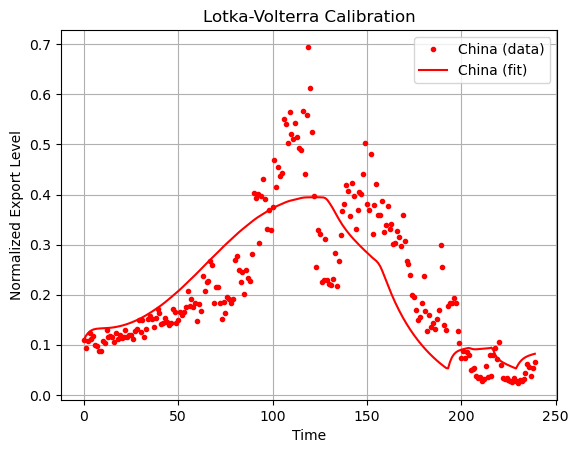

In [128]:
# Plot
plt.plot(t_data[:len(data[0])], data[0], 'r.', label='China (data)')
plt.plot(t_data, sol.y[0], 'r-', label='China (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

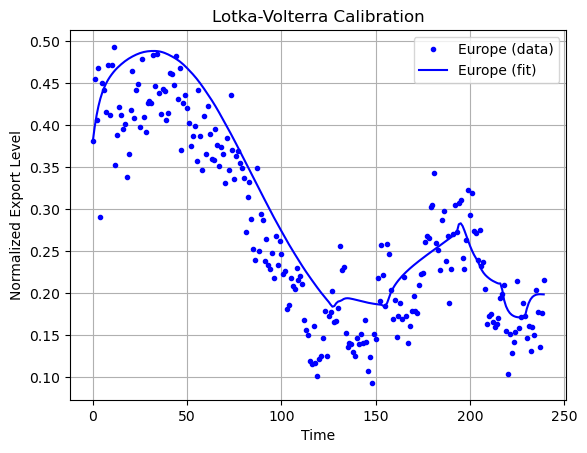

In [129]:
plt.plot(t_data[:len(data[1])], data[1], 'b.', label='Europe (data)')
plt.plot(t_data, sol.y[1], 'b-', label='Europe (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

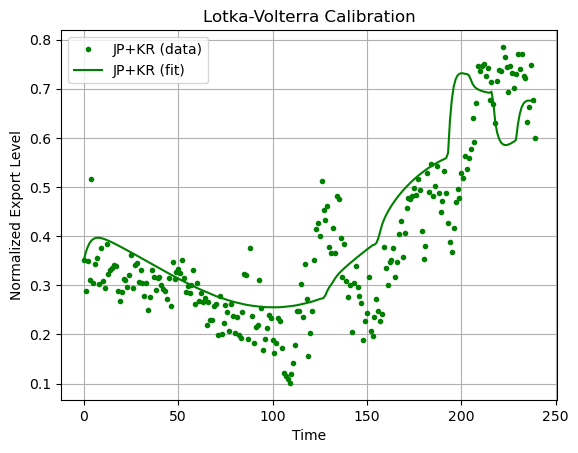

In [130]:
plt.plot(t_data[:len(data[2])], data[2], 'g.', label='JP+KR (data)')
plt.plot(t_data, sol.y[2], 'g-', label='JP+KR (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

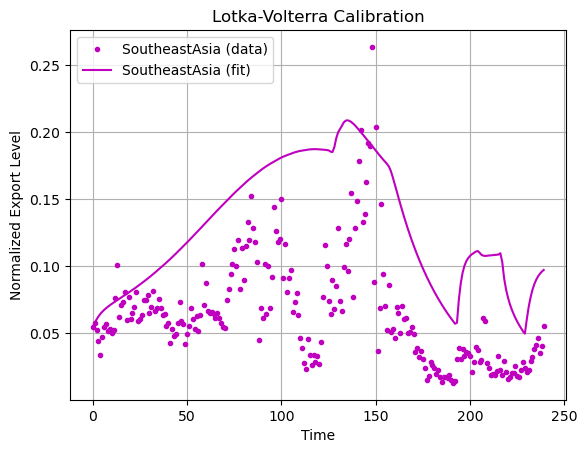

In [131]:
plt.plot(t_data[:len(data[3])], data[3], 'm.', label='SoutheastAsia (data)')
plt.plot(t_data, sol.y[3], 'm-', label='SoutheastAsia (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

## Model Calibration - lkh and llkh

In [ ]:
# Define likelihood 
def compute_likelihood(data, data_mod):
    lkh = np.prod(nbinom.pmf(data,data_mod)) #poisson likelihood to observe the data with a model
    return lkh

# Define log-likelihood 
def compute_loglikelihood(data, data_mod):
    llkh = np.sum(np.log(poisson.pmf(data,data_mod))) #poisson likelihood to observe the data with a model
    return llkh

## Model Calibration - MSE

In [ ]:
china_data = df_normalized['China']
europe_data = df_normalized['Europe']
jpkr_data = df_normalized['JP+KR']
southeastasia_data = df_normalized['SoutheastAsia']

# Stack data for comparison
data = np.vstack([china_data, europe_data, jpkr_data, southeastasia_data])  # shape (4, T)
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months